# Global Store×SKU Forecasting (Strategy 1)

Train a **single global model** at Store×SKU granularity, aggregate to Store level, evaluate accuracy, and generate next-N-week forecasts.

In [1]:
# Imports
import os
import math
import numpy as np
import pandas as pd
from datetime import timedelta
from typing import Tuple, Dict, List
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Config
CSV_PATH = "/home/zeal/Desktop/inventory-saas/boing/backend/csvs/sale data.csv"   # <- change if needed
DATE_COL = "Date"
STORE_COL = "Store ID"
SKU_COL = "Product ID"
TARGET_COL = "Units Sold"

# Forecast horizon (weeks). Change this and re-run the forecast cell.
N_WEEKS_AHEAD = 4

# Output paths
OUT_DIR = "/home/zeal/Desktop/inventory-saas/boing/backend/csvs/forecast_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

/home/zeal/Desktop/inventory-saas/env/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [13]:
# not needed as data is already weekly

# # Load data
df = pd.read_csv(CSV_PATH)
# df.columns = [c.strip() for c in df.columns]

# # Parse datetime (sample is day-first like 01-01-2022)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], dayfirst=True, errors="coerce")
# df = df.sort_values([STORE_COL, SKU_COL, DATE_COL])

# # Drop rows without valid date or target
df = df.dropna(subset=[DATE_COL, TARGET_COL]).copy()

# # Create composite series id
df["series_id"] = df[STORE_COL].astype(str) + "__" + df[SKU_COL].astype(str)

# # Sort by series and date
# df = df.sort_values(["series_id", DATE_COL]).reset_index(drop=True)

# # Drop leakage columns if present
# for col in ["Demand Forecast"]:
#     if col in df.columns:
#         df = df.drop(columns=[col])

# # (Optional) If Units Ordered isn't known before sales at forecast time, drop it
# # if "Units Ordered" in df.columns:
# #     df = df.drop(columns=["Units Ordered"])

# print("Rows:", len(df), "| Series:", df['series_id'].nunique())
# df.head()


In [14]:
# # not needed as data is already weekly

# def infer_freq_per_series(df: pd.DataFrame, date_col: str, id_col: str) -> str:
#     """Infer if data is daily or weekly by checking median gap across all series."""
#     gaps = []
#     for sid, g in df[[id_col, date_col]].drop_duplicates().groupby(id_col):
#         g = g.sort_values(date_col)
#         d = g[date_col].diff().dropna().dt.days
#         if len(d) > 0:
#             gaps.append(d.median())
#     if not gaps:
#         return "D"
#     med = np.median(gaps)
#     # Heuristic: <=2 days -> daily; else weekly
#     return "D" if med <= 2 else "W"

# freq = infer_freq_per_series(df, DATE_COL, "series_id")
# print("Inferred frequency:", freq)


In [15]:
def add_time_features_weekly(g: pd.DataFrame) -> pd.DataFrame:
    g = g.copy()
    g["week"] = g[DATE_COL].dt.isocalendar().week.astype(int)
    g["month"] = g[DATE_COL].dt.month
    g["year"] = g[DATE_COL].dt.year
    return g


def add_lags_weekly(g: pd.DataFrame, target: str) -> pd.DataFrame:
    g = g.copy()
    # Lags in weeks: 1-week, 4-weeks (~1 month), 12-weeks (~quarter)
    for l in [1, 4, 12]:
        g[f"lag_{l}"] = g[target].shift(l)
    g["roll_mean_4"] = g[target].rolling(4, min_periods=1).mean().shift(1)
    g["roll_mean_12"] = g[target].rolling(12, min_periods=1).mean().shift(1)
    return g


def build_features_weekly(df: pd.DataFrame) -> pd.DataFrame:
    out = []
    for sid, g in df.groupby("series_id", sort=False):
        g = add_time_features_weekly(g)
        g = add_lags_weekly(g, TARGET_COL)
        out.append(g)
    feat = pd.concat(out, axis=0).reset_index(drop=True)
    # Drop early rows with missing lags
    feat = feat.dropna(subset=[f"lag_{l}" for l in [1, 4, 12]])
    return feat

df["series_id"] = df[STORE_COL].astype(str) + "__" + df[SKU_COL].astype(str)
feat_df = build_features_weekly(df)

feature_cols = [
    "week", "month", "year",
    "lag_1", "lag_4", "lag_12",
    "roll_mean_4", "roll_mean_12"
]


X_all = feat_df[feature_cols]
y_all = feat_df[TARGET_COL].astype(float).values

print("Feature rows:", len(feat_df))
feat_df.head()


Feature rows: 71900


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,...,Seasonality,series_id,week,month,year,lag_1,lag_4,lag_12,roll_mean_4,roll_mean_12
12,2022-01-13,S001,P0001,Furniture,East,110,80,190,78.64,17.27,...,Spring,S001__P0001,2,1,2022,104.0,350.0,127.0,126.50,89.166667
13,2022-01-14,S001,P0001,Toys,North,199,177,44,193.23,90.05,...,Winter,S001__P0001,2,1,2022,80.0,36.0,81.0,59.00,85.250000
14,2022-01-15,S001,P0001,Groceries,North,290,176,94,170.06,98.04,...,Spring,S001__P0001,2,1,2022,177.0,16.0,5.0,94.25,93.250000
15,2022-01-16,S001,P0001,Groceries,East,104,97,189,114.65,11.39,...,Winter,S001__P0001,2,1,2022,176.0,104.0,58.0,134.25,107.500000
16,2022-01-17,S001,P0001,Groceries,East,134,69,95,73.59,95.27,...,Summer,S001__P0001,3,1,2022,97.0,80.0,147.0,132.50,110.750000


In [16]:
def time_based_split(feat: pd.DataFrame, date_col: str, valid_frac: float = 0.2):
    # Split by time globally (last 20% timestamps become validation)
    unique_dates = np.sort(feat[date_col].unique())
    cutoff_idx = max(1, int((1 - valid_frac) * len(unique_dates)))
    cutoff_date = unique_dates[cutoff_idx]
    train_mask = feat[date_col] < cutoff_date
    valid_mask = feat[date_col] >= cutoff_date
    return train_mask, valid_mask, cutoff_date

train_mask, valid_mask, cutoff_date = time_based_split(feat_df, DATE_COL, valid_frac=0.2)

X_train, y_train = feat_df.loc[train_mask, feature_cols], feat_df.loc[train_mask, TARGET_COL].values
X_valid, y_valid = feat_df.loc[valid_mask, feature_cols], feat_df.loc[valid_mask, TARGET_COL].values

model = HistGradientBoostingRegressor(max_depth=6, learning_rate=0.1, max_iter=300, l2_regularization=0.0)
model.fit(X_train, y_train)

valid_pred = model.predict(X_valid)

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0 if mask.any() else np.nan

rmse = math.sqrt(mean_squared_error(y_valid, valid_pred))
mae = mean_absolute_error(y_valid, valid_pred)
mape_val = mape(y_valid, valid_pred)

print(f"Validation: RMSE={rmse:.2f} | MAE={mae:.2f} | MAPE={mape_val:.2f}%")


Validation: RMSE=108.18 | MAE=88.84 | MAPE=346.14%


In [17]:
# Compose validation frame
valid_df = feat_df.loc[valid_mask, ["series_id", STORE_COL, SKU_COL, DATE_COL, TARGET_COL]].copy()
valid_df["y_pred"] = valid_pred

# SKU-level metrics
sku_metrics = []
for sid, g in valid_df.groupby("series_id"):
    sku_metrics.append({
        "series_id": sid,
        STORE_COL: g[STORE_COL].iloc[0],
        SKU_COL: g[SKU_COL].iloc[0],
        "RMSE": math.sqrt(mean_squared_error(g[TARGET_COL], g["y_pred"])),
        "MAE": mean_absolute_error(g[TARGET_COL], g["y_pred"]),
        "MAPE": mape(g[TARGET_COL], g["y_pred"]),
        "n": len(g)
    })
sku_metrics_df = pd.DataFrame(sku_metrics).sort_values("MAPE")

# Store-level metrics (aggregate actuals & preds)
store_metrics = []
for store_id, g in valid_df.groupby(STORE_COL):
    agg = g.groupby(DATE_COL, as_index=False)[[TARGET_COL, "y_pred"]].sum()
    store_metrics.append({
        STORE_COL: store_id,
        "RMSE": math.sqrt(mean_squared_error(agg[TARGET_COL], agg["y_pred"])),
        "MAE": mean_absolute_error(agg[TARGET_COL], agg["y_pred"]),
        "MAPE": mape(agg[TARGET_COL], agg["y_pred"]),
        "n": len(agg)
    })
store_metrics_df = pd.DataFrame(store_metrics).sort_values("MAPE")

# Save metrics
sku_metrics_path = os.path.join(OUT_DIR, "metrics_sku.csv")
store_metrics_path = os.path.join(OUT_DIR, "metrics_store.csv")
sku_metrics_df.to_csv(sku_metrics_path, index=False)
store_metrics_df.to_csv(store_metrics_path, index=False)

print("Saved metrics to:")
print("-", sku_metrics_path)
print("-", store_metrics_path)

sku_metrics_df.head(), store_metrics_df.head()


Saved metrics to:
- /home/zeal/Desktop/inventory-saas/boing/backend/csvs/forecast_outputs/metrics_sku.csv
- /home/zeal/Desktop/inventory-saas/boing/backend/csvs/forecast_outputs/metrics_store.csv


(      series_id Store ID Product ID        RMSE        MAE        MAPE    n
 74  S004__P0015     S004      P0015  101.778622  86.713843  155.279879  144
 79  S004__P0020     S004      P0020  111.345593  86.976617  174.656384  144
 71  S004__P0012     S004      P0012   93.919739  76.766173  175.515705  144
 53  S003__P0014     S003      P0014  113.093312  90.628637  189.645452  144
 81  S005__P0002     S005      P0002  104.068135  84.145598  191.535998  144,
   Store ID        RMSE         MAE       MAPE    n
 3     S004  433.718582  349.716508  13.828107  144
 0     S001  483.604005  390.379674  15.149489  144
 2     S003  531.331149  422.628609  15.825821  144
 4     S005  528.041604  417.646846  16.463747  144
 1     S002  501.021058  405.787751  16.547656  144)

In [18]:
def forecast_series_recursive_weekly(history: pd.DataFrame, model, n_weeks_ahead: int) -> pd.DataFrame:
    """
    Recursive weekly forecast using lagged features.
    Returns a DataFrame with Date and y_pred for the forecast horizon.
    """
    hist = history.copy().sort_values(DATE_COL)
    
    # Build initial lags and time features
    hist = add_time_features_weekly(hist)
    hist = add_lags_weekly(hist, TARGET_COL)
    
    # Keep only necessary columns for recursive forecasting
    needed_cols = [DATE_COL, TARGET_COL]
    current = hist[needed_cols].copy()
    
    last_date = current[DATE_COL].max()
    preds = []

    for step in range(n_weeks_ahead):
        next_date = last_date + pd.Timedelta(weeks=step + 1)
        
        # Prepare feature row
        row = {
            DATE_COL: next_date,
            "week": int(next_date.isocalendar().week),
            "month": next_date.month,
            "year": next_date.year,
            "lag_1": current.iloc[-1][TARGET_COL],
            "lag_4": current.iloc[-4][TARGET_COL] if len(current) >= 4 else current.iloc[-1][TARGET_COL],
            "lag_12": current.iloc[-12][TARGET_COL] if len(current) >= 12 else current.iloc[-1][TARGET_COL],
            "roll_mean_4": current[TARGET_COL].tail(4).mean(),
            "roll_mean_12": current[TARGET_COL].tail(12).mean() if len(current) >= 12 else current[TARGET_COL].mean()
        }

        X_row = pd.DataFrame([row])[[
            "week", "month", "year",
            "lag_1", "lag_4", "lag_12",
            "roll_mean_4", "roll_mean_12"
        ]]

        y_hat = float(model.predict(X_row)[0])
        preds.append({DATE_COL: next_date, "y_pred": y_hat})
        
        # Append predicted point for next iteration lags
        current = pd.concat([current, pd.DataFrame([{DATE_COL: next_date, TARGET_COL: y_hat}])], ignore_index=True)

    return pd.DataFrame(preds)


# --- Forecast per series ---
future_rows = []
for sid, g in df.groupby("series_id", sort=False):
    fc = forecast_series_recursive_weekly(g[[DATE_COL, TARGET_COL]], model, n_weeks_ahead=N_WEEKS_AHEAD)
    fc["series_id"] = sid
    fc[STORE_COL] = g[STORE_COL].iloc[0]
    fc[SKU_COL] = g[SKU_COL].iloc[0]
    future_rows.append(fc)

future_df = pd.concat(future_rows, axis=0).reset_index(drop=True)

# Aggregate to weekly for reporting
future_df["week_start"] = future_df[DATE_COL] - pd.to_timedelta(future_df[DATE_COL].dt.weekday, unit="D")

sku_future_weekly = (future_df
    .groupby([STORE_COL, SKU_COL, "series_id", "week_start"], as_index=False)["y_pred"]
    .sum()
    .rename(columns={"y_pred": "forecast_units"}))

store_future_weekly = (sku_future_weekly
    .groupby([STORE_COL, "week_start"], as_index=False)["forecast_units"].sum())

# Save forecasts
sku_future_path = os.path.join(OUT_DIR, "forecast_next_weeks_sku.csv")
store_future_path = os.path.join(OUT_DIR, "forecast_next_weeks_store.csv")
sku_future_weekly.to_csv(sku_future_path, index=False)
store_future_weekly.to_csv(store_future_path, index=False)

print("Saved forecasts to:")
print("-", sku_future_path)
print("-", store_future_path)

sku_future_weekly.head(), store_future_weekly.head()


Saved forecasts to:
- /home/zeal/Desktop/inventory-saas/boing/backend/csvs/forecast_outputs/forecast_next_weeks_sku.csv
- /home/zeal/Desktop/inventory-saas/boing/backend/csvs/forecast_outputs/forecast_next_weeks_store.csv


(  Store ID Product ID    series_id week_start  forecast_units
 0     S001      P0001  S001__P0001 2024-01-08      136.521556
 1     S001      P0001  S001__P0001 2024-01-15      138.913441
 2     S001      P0001  S001__P0001 2024-01-22      137.531360
 3     S001      P0001  S001__P0001 2024-01-29      137.531360
 4     S001      P0002  S001__P0002 2024-01-08      138.789825,
   Store ID week_start  forecast_units
 0     S001 2024-01-08     2734.127807
 1     S001 2024-01-15     2759.096314
 2     S001 2024-01-22     2748.326404
 3     S001 2024-01-29     2736.667590
 4     S002 2024-01-08     2726.927245)

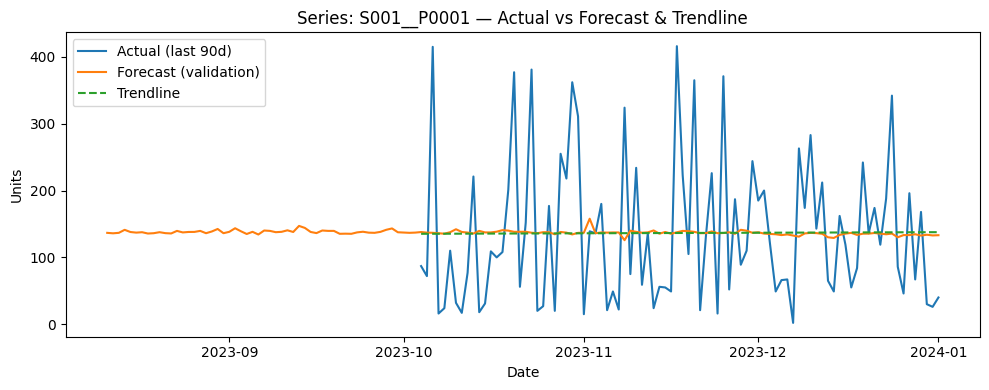

In [24]:
# Pick a sample series with enough history
if not df['series_id'].empty:
    sample_sid = df['series_id'].value_counts().index[0]
    hist = df[df['series_id'] == sample_sid].sort_values(DATE_COL)[[DATE_COL, TARGET_COL]].copy()

    # Validation preds for this SKU
    sample_valid = valid_df[valid_df['series_id'] == sample_sid].copy()

    plt.figure(figsize=(10, 4))
    if len(hist) > 0:
        plt.plot(hist[DATE_COL].tail(90), hist[TARGET_COL].tail(90), label="Actual (last 90d)")
    if not sample_valid.empty:
        plt.plot(sample_valid[DATE_COL], sample_valid["y_pred"], label="Forecast (validation)")

    # Trendline on recent actuals
    if len(hist) > 2:
        recent = hist.tail(90)
        x = np.arange(len(recent))
        z = np.polyfit(x, recent[TARGET_COL].values, 1)  # linear trend
        p = np.poly1d(z)
        plt.plot(recent[DATE_COL], p(x), linestyle="--", label="Trendline")

    plt.title(f"Series: {sample_sid} — Actual vs Forecast & Trendline")
    plt.xlabel("Date"); plt.ylabel("Units")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No series available to plot.")


In [22]:
# Show quick peeks
print("Top of SKU-level metrics:")
display(sku_metrics_df.head())

print("\nTop of Store-level metrics:")
display(store_metrics_df.head())

print("\nTop of SKU-level next N weeks forecast:")
display(sku_future_weekly.head())

print("\nTop of Store-level next N weeks forecast:")
display(store_future_weekly.head())

print("\nSaved files:")
print("-", os.path.join(OUT_DIR, "metrics_sku.csv"))
print("-", os.path.join(OUT_DIR, "metrics_store.csv"))
print("-", os.path.join(OUT_DIR, "forecast_next_weeks_sku.csv"))
print("-", os.path.join(OUT_DIR, "forecast_next_weeks_store.csv"))


Top of SKU-level metrics:


,series_id,Store ID,Product ID,RMSE,MAE,MAPE,n
74,S004__P0015,S004,P0015,101.778622,86.713843,155.279879,144
79,S004__P0020,S004,P0020,111.345593,86.976617,174.656384,144
71,S004__P0012,S004,P0012,93.919739,76.766173,175.515705,144
53,S003__P0014,S003,P0014,113.093312,90.628637,189.645452,144
81,S005__P0002,S005,P0002,104.068135,84.145598,191.535998,144



Top of Store-level metrics:


,Store ID,RMSE,MAE,MAPE,n
3,S004,433.718582,349.716508,13.828107,144
0,S001,483.604005,390.379674,15.149489,144
2,S003,531.331149,422.628609,15.825821,144
4,S005,528.041604,417.646846,16.463747,144
1,S002,501.021058,405.787751,16.547656,144



Top of SKU-level next N weeks forecast:


,Store ID,Product ID,series_id,week_start,forecast_units
0,S001,P0001,S001__P0001,2024-01-08,136.521556
1,S001,P0001,S001__P0001,2024-01-15,138.913441
2,S001,P0001,S001__P0001,2024-01-22,137.531360
3,S001,P0001,S001__P0001,2024-01-29,137.531360
4,S001,P0002,S001__P0002,2024-01-08,138.789825



Top of Store-level next N weeks forecast:


,Store ID,week_start,forecast_units
0,S001,2024-01-08,2734.127807
1,S001,2024-01-15,2759.096314
2,S001,2024-01-22,2748.326404
3,S001,2024-01-29,2736.667590
4,S002,2024-01-08,2726.927245



Saved files:
- /home/zeal/Desktop/inventory-saas/boing/backend/csvs/forecast_outputs/metrics_sku.csv
- /home/zeal/Desktop/inventory-saas/boing/backend/csvs/forecast_outputs/metrics_store.csv
- /home/zeal/Desktop/inventory-saas/boing/backend/csvs/forecast_outputs/forecast_next_weeks_sku.csv
- /home/zeal/Desktop/inventory-saas/boing/backend/csvs/forecast_outputs/forecast_next_weeks_store.csv


In [23]:
import joblib

# Suppose 'model' is your trained model object
MODEL_PATH = "/home/zeal/Desktop/inventory-saas/boing/backend/app/utils/model.pkl"

# Save the model
joblib.dump(model, MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")


Model saved to /home/zeal/Desktop/inventory-saas/boing/backend/app/utils/model.pkl


In [25]:
import joblib
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os

class SimpleForecastPredictor:
    def __init__(self, model_path, data_path):
        """
        Initialize predictor with model and data source
        
        Args:
            model_path: Path to saved model.pkl file
            data_path: Path to your sales data CSV file
        """
        self.model = joblib.load(model_path)
        self.data_path = data_path
        self.feature_cols = [
            "week", "month", "year",
            "lag_1", "lag_4", "lag_12", 
            "roll_mean_4", "roll_mean_12"
        ]
        
        # Load and prepare the full dataset
        self._load_data()
    
    def _load_data(self):
        """Load and preprocess the sales data"""
        print("Loading sales data...")
        self.df = pd.read_csv(self.data_path)
        
        # Clean column names and parse dates
        self.df.columns = [c.strip() for c in self.df.columns]
        self.df["Date"] = pd.to_datetime(self.df["Date"], dayfirst=True, errors="coerce")
        
        # Create series ID
        self.df["series_id"] = (self.df["Store ID"].astype(str) + 
                               "__" + self.df["Product ID"].astype(str))
        
        # Sort and clean
        self.df = self.df.sort_values(["series_id", "Date"]).reset_index(drop=True)
        self.df = self.df.dropna(subset=["Date", "Units Sold"])
        
        print(f"Loaded {len(self.df)} records for {self.df['series_id'].nunique()} unique series")
    
    def _get_series_data(self, store_id, product_id):
        """Get historical data for a specific store-product combination"""
        series_id = f"{store_id}__{product_id}"
        series_data = self.df[self.df["series_id"] == series_id].copy()
        
        if series_data.empty:
            raise ValueError(f"No data found for Store {store_id}, Product {product_id}")
        
        return series_data.sort_values("Date")
    
    def _add_time_features(self, df):
        """Add time-based features"""
        df = df.copy()
        df["week"] = df["Date"].dt.isocalendar().week.astype(int)
        df["month"] = df["Date"].dt.month
        df["year"] = df["Date"].dt.year
        return df
    
    def _add_lag_features(self, df):
        """Add lag and rolling mean features"""
        df = df.copy()
        
        # Lag features
        for lag in [1, 4, 12]:
            df[f"lag_{lag}"] = df["Units Sold"].shift(lag)
        
        # Rolling means
        df["roll_mean_4"] = df["Units Sold"].rolling(4, min_periods=1).mean().shift(1)
        df["roll_mean_12"] = df["Units Sold"].rolling(12, min_periods=1).mean().shift(1)
        
        return df
    
    def predict(self, store_id, product_id, n_periods_ahead=4):
        """
        Main prediction method - just pass Store ID, Product ID, and number of periods
        
        Args:
            store_id: Store identifier (e.g., 'S001')
            product_id: Product identifier (e.g., 'P0001')
            n_periods_ahead: Number of periods (days/weeks) to forecast (default: 4)
        
        Returns:
            Dictionary with prediction results and metadata
        """
        try:
            # Get historical data for this series
            series_data = self._get_series_data(store_id, product_id)
            
            # Add features
            series_data = self._add_time_features(series_data)
            series_data = self._add_lag_features(series_data)
            
            # Check if we have enough data for all lags
            complete_data = series_data.dropna(subset=[f"lag_{l}" for l in [1, 4, 12]])
            if len(complete_data) == 0:
                raise ValueError(f"Insufficient data for Store {store_id}, Product {product_id}. Need at least 12 weeks of history.")
            
            # Prepare for recursive forecasting
            forecast_data = series_data[["Date", "Units Sold"]].copy()
            predictions = []
            last_date = forecast_data["Date"].max()
            
            # Generate predictions recursively
            for period in range(1, n_periods_ahead + 1):
                next_date = last_date + pd.Timedelta(weeks=period)  # Assuming weekly periods
                
                # Get most recent values for features
                recent_sales = forecast_data["Units Sold"].tail(12).values
                
                # Create feature row
                feature_row = {
                    "week": int(next_date.isocalendar().week),
                    "month": next_date.month,
                    "year": next_date.year,
                    "lag_1": recent_sales[-1] if len(recent_sales) >= 1 else 0,
                    "lag_4": recent_sales[-4] if len(recent_sales) >= 4 else recent_sales[-1],
                    "lag_12": recent_sales[-12] if len(recent_sales) >= 12 else recent_sales[0],
                    "roll_mean_4": np.mean(recent_sales[-4:]) if len(recent_sales) >= 4 else np.mean(recent_sales),
                    "roll_mean_12": np.mean(recent_sales) if len(recent_sales) >= 12 else np.mean(recent_sales)
                }
                
                # Make prediction
                X = pd.DataFrame([feature_row])[self.feature_cols]
                pred_value = self.model.predict(X)[0]
                pred_value = max(0, pred_value)  # Ensure non-negative predictions
                
                predictions.append({
                    "period": period,
                    "date": next_date.strftime("%Y-%m-%d"),
                    "predicted_units": round(pred_value, 2)
                })
                
                # Add prediction to history for next iteration
                new_row = pd.DataFrame([{
                    "Date": next_date, 
                    "Units Sold": pred_value
                }])
                forecast_data = pd.concat([forecast_data, new_row], ignore_index=True)
            
            # Calculate summary statistics
            recent_avg = series_data["Units Sold"].tail(12).mean()
            total_forecast = sum([p["predicted_units"] for p in predictions])
            
            return {
                "store_id": store_id,
                "product_id": product_id,
                "forecast_periods": n_periods_ahead,
                "predictions": predictions,
                "summary": {
                    "total_predicted_units": round(total_forecast, 2),
                    "avg_per_period_prediction": round(total_forecast / n_periods_ahead, 2),
                    "recent_12_period_avg": round(recent_avg, 2),
                    "data_points_used": len(series_data),
                    "last_actual_date": series_data["Date"].max().strftime("%Y-%m-%d"),
                    "last_actual_units": series_data["Units Sold"].iloc[-1]
                }
            }
            
        except Exception as e:
            return {
                "error": str(e),
                "store_id": store_id,
                "product_id": product_id
            }
    
    def predict_multiple_series(self, store_product_pairs, n_periods_ahead=4):
        """
        Predict for multiple store-product combinations
        
        Args:
            store_product_pairs: List of tuples [(store_id, product_id), ...]
            n_periods_ahead: Number of periods to forecast
        
        Returns:
            List of prediction results
        """
        results = []
        for store_id, product_id in store_product_pairs:
            result = self.predict(store_id, product_id, n_periods_ahead)
            results.append(result)
        return results
    
    def get_available_series(self):
        """Get list of available store-product combinations"""
        available = self.df[["Store ID", "Product ID"]].drop_duplicates()
        return available.values.tolist()
    
    def get_series_info(self, store_id, product_id):
        """Get basic info about a series"""
        try:
            series_data = self._get_series_data(store_id, product_id)
            return {
                "store_id": store_id,
                "product_id": product_id,
                "data_points": len(series_data),
                "date_range": {
                    "start": series_data["Date"].min().strftime("%Y-%m-%d"),
                    "end": series_data["Date"].max().strftime("%Y-%m-%d")
                },
                "units_sold": {
                    "total": series_data["Units Sold"].sum(),
                    "avg_weekly": round(series_data["Units Sold"].mean(), 2),
                    "min": series_data["Units Sold"].min(),
                    "max": series_data["Units Sold"].max()
                }
            }
        except Exception as e:
            return {"error": str(e)}

# Example usage
if __name__ == "__main__":
    # Initialize predictor
    MODEL_PATH = "/home/zeal/Desktop/inventory-saas/boing/backend/app/utils/model.pkl"
    DATA_PATH = "/home/zeal/Desktop/inventory-saas/boing/backend/csvs/sale data.csv"
    
    predictor = SimpleForecastPredictor(MODEL_PATH, DATA_PATH)
    
    # Example 1: Simple prediction for one store-product
    print("=== Single Prediction ===")
    result = predictor.predict("S001", "P0001", n_periods_ahead=7)  # Predict 7 periods ahead
    
    if "error" not in result:
        print(f"Store: {result['store_id']}, Product: {result['product_id']}")
        print(f"Total forecast for {result['forecast_periods']} periods: {result['summary']['total_predicted_units']} units")
        print("\nPeriod-by-period predictions:")
        for pred in result['predictions']:
            print(f"  Period {pred['period']} ({pred['date']}): {pred['predicted_units']} units")
    else:
        print(f"Error: {result['error']}")
    
    # Example 2: Multiple predictions
    print("\n=== Multiple Predictions ===")
    pairs = [("S001", "P0001"), ("S002", "P0002"), ("S003", "P0003")]
    multi_results = predictor.predict_multiple_series(pairs, n_periods_ahead=5)
    
    for result in multi_results:
        if "error" not in result:
            print(f"{result['store_id']}-{result['product_id']}: {result['summary']['total_predicted_units']} units over {result['forecast_periods']} periods")
        else:
            print(f"{result['store_id']}-{result['product_id']}: {result['error']}")
    
    # Example 3: Get available series
    print("\n=== Available Series (first 10) ===")
    available = predictor.get_available_series()[:10]
    for store, product in available:
        print(f"Store: {store}, Product: {product}")
    
    # Example 4: Get series info
    print("\n=== Series Information ===")
    info = predictor.get_series_info("S001", "P0001")
    if "error" not in info:
        print(f"Data points: {info['data_points']}")
        print(f"Date range: {info['date_range']['start']} to {info['date_range']['end']}")
        print(f"Average weekly sales: {info['units_sold']['avg_weekly']}")

Loading sales data...
Loaded 73100 records for 100 unique series
=== Single Prediction ===
Store: S001, Product: P0001
Total forecast for 7 periods: 960.5 units

Period-by-period predictions:
  Period 1 (2024-01-08): 136.52 units
  Period 2 (2024-01-15): 138.91 units
  Period 3 (2024-01-22): 137.53 units
  Period 4 (2024-01-29): 137.53 units
  Period 5 (2024-02-05): 136.67 units
  Period 6 (2024-02-12): 136.67 units
  Period 7 (2024-02-19): 136.67 units

=== Multiple Predictions ===
S001-P0001: 687.16 units over 5 periods
S002-P0002: 687.13 units over 5 periods
S003-P0003: 684.95 units over 5 periods

=== Available Series (first 10) ===
Store: S001, Product: P0001
Store: S001, Product: P0002
Store: S001, Product: P0003
Store: S001, Product: P0004
Store: S001, Product: P0005
Store: S001, Product: P0006
Store: S001, Product: P0007
Store: S001, Product: P0008
Store: S001, Product: P0009
Store: S001, Product: P0010

=== Series Information ===
Data points: 731
Date range: 2022-01-01 to 2024